In [12]:
import math
from typing import List, Tuple, Optional, Union, Any
from functools import cmp_to_key
from data import raw

# --- Konfiguracja i Stałe ---
TOLERANCE = 1e-9

# --- Struktury Danych ---

class Vertex:
    """Reprezentuje wierzchołek w grafie planarnym."""
    def __init__(self, x_coord: float, y_coord: float):
        self.x = x_coord
        self.y = y_coord
        self.adj_out: List[Tuple['Vertex', int]] = []
        self.adj_in: List[Tuple['Vertex', int]] = []
        self.accumulated_weight_in = 0
        self.accumulated_weight_out = 0

    @property
    def coords(self) -> Tuple[float, float]:
        return self.x, self.y

    def __repr__(self):
        return f"V({self.x:.2f}, {self.y:.2f})"

class MonotoneChain:
    """Reprezentuje łańcuch monotoniczny (separator)."""
    def __init__(self):
        self.path_vertices: List[Tuple[float, float]] = []
        self.path_segments: List[Tuple[Tuple[float, float], Tuple[float, float]]] = []

    def add_node(self, coords: Tuple[float, float]):
        self.path_vertices.append(coords)

    def add_segment(self, start: Tuple[float, float], end: Tuple[float, float]):
        self.path_segments.append((start, end))

class SearchTreeNode:
    """Węzeł drzewa poszukiwań (BST)."""
    def __init__(self, segments: List, chain_ref: MonotoneChain, parent: Optional['SearchTreeNode'] = None):
        self.left_child: Optional[SearchTreeNode] = None
        self.right_child: Optional[SearchTreeNode] = None
        self.parent = parent
        self.segments = segments
        self.chain_ref = chain_ref

# --- Narzędzia Geometryczne ---

def cross_product(o: Tuple[float, float], a: Tuple[float, float], b: Tuple[float, float]) -> float:
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

# --- Przetwarzanie Grafu ---

def build_graph(raw_vertices: List[Tuple[float, float]], raw_edges: List[Tuple[int, int]]) -> List[Vertex]:
    graph_nodes = [Vertex(x, y) for x, y in raw_vertices]
    for start_idx, end_idx in raw_edges:
        u, v = sorted((start_idx, end_idx))
        node_u = graph_nodes[u]
        node_v = graph_nodes[v]
        node_u.adj_out.append((node_v, 1))
        node_v.adj_in.append((node_u, 1))
    return graph_nodes

def compute_planar_weights(graph: List[Vertex]):
    # 1. Sortowanie krawędzi kątowo
    for node in graph:
        center = node.coords
        def angular_comparator(edge1, edge2):
            p1 = edge1[0].coords
            p2 = edge2[0].coords
            cp = cross_product(center, p1, p2)
            if math.isclose(cp, 0, abs_tol=TOLERANCE): return 0
            return -1 if cp > 0 else 1

        node.adj_out.sort(key=cmp_to_key(angular_comparator))
        node.adj_in.sort(key=cmp_to_key(lambda a, b: -1 * angular_comparator(a, b)))

    # 2. Propagacja wag (dół -> góra)
    for i in range(1, len(graph) - 1):
        v = graph[i]
        v.accumulated_weight_in = sum(w for _, w in v.adj_in)
        v.accumulated_weight_out = len(v.adj_out)
        if v.accumulated_weight_in > v.accumulated_weight_out:
            target_node, current_w = v.adj_out.pop(0)
            new_weight = current_w + v.accumulated_weight_in - v.accumulated_weight_out
            v.adj_out.insert(0, (target_node, new_weight))
            for idx, (neighbor, w) in enumerate(target_node.adj_in):
                if neighbor == v:
                    target_node.adj_in[idx] = (v, new_weight)
                    break

    # 3. Propagacja wag (góra -> dół)
    for i in range(len(graph) - 2, 0, -1):
        v = graph[i]
        v.accumulated_weight_in = sum(w for _, w in v.adj_in)
        v.accumulated_weight_out = sum(w for _, w in v.adj_out)
        if v.accumulated_weight_out > v.accumulated_weight_in:
            source_node, current_w = v.adj_in.pop(0)
            new_weight = current_w + v.accumulated_weight_out - v.accumulated_weight_in
            v.adj_in.insert(0, (source_node, new_weight))
            for idx, (neighbor, w) in enumerate(source_node.adj_out):
                if neighbor == v:
                    source_node.adj_out[idx] = (v, new_weight)
                    break

def generate_monotone_chains(graph: List[Vertex]) -> List[MonotoneChain]:
    source_node = graph[0]
    total_chains = sum(w for _, w in source_node.adj_out)
    chains = [MonotoneChain() for _ in range(total_chains)]
    
    for chain in chains:
        current_v = source_node
        while current_v.adj_out:
            chain.add_node(current_v.coords)
            chosen_idx = -1
            for i in range(len(current_v.adj_out) - 1, -1, -1):
                neighbor, weight = current_v.adj_out[i]
                if weight > 0:
                    chosen_idx = i
                    break
            if chosen_idx == -1: break
            next_v, w = current_v.adj_out[chosen_idx]
            current_v.adj_out[chosen_idx] = (next_v, w - 1)
            current_v = next_v
        chain.add_node(current_v.coords)
        
        verts = chain.path_vertices
        for k in range(len(verts) - 1):
            chain.add_segment(verts[k], verts[k+1])
    return chains

def create_search_structure(chains: List[MonotoneChain], parent: Optional[SearchTreeNode] = None) -> Optional[SearchTreeNode]:
    if not chains: return None
    mid_idx = len(chains) // 2
    median_chain = chains[mid_idx]
    node = SearchTreeNode(median_chain.path_segments, median_chain, parent)
    node.left_child = create_search_structure(chains[:mid_idx], node)
    node.right_child = create_search_structure(chains[mid_idx + 1:], node)
    return node

# --- Logika Zapytań ---

def find_position_relative_to_chain(point: Tuple[float, float], node: SearchTreeNode) -> int:
    px, py = point
    target_segment = None
    for p1, p2 in node.segments:
        if p1[1] <= py <= p2[1]: # Zakładamy monotoniczność Y
            target_segment = (p1, p2)
            break
    
    if target_segment is None: return 1
    
    cp = cross_product(target_segment[0], target_segment[1], point)
    if math.isclose(cp, 0, abs_tol=TOLERANCE):
        if min(target_segment[0][0], target_segment[1][0]) <= px <= max(target_segment[0][0], target_segment[1][0]):
            return 0
        return -1 if px > target_segment[0][0] else 1
    return -1 if cp < 0 else 1

def query_search_tree(point: Tuple[float, float], node: Optional[SearchTreeNode], 
                     closest_left: Optional[MonotoneChain] = None,
                     closest_right: Optional[MonotoneChain] = None) -> Union[MonotoneChain, Tuple[MonotoneChain, MonotoneChain]]:
    """Zwraca parę separatorów (lewy, prawy) otaczających punkt."""
    if node is None:
        # Zwracamy parę separatorów, pomiędzy którymi wylądowaliśmy
        return (closest_left, closest_right)
        
    position = find_position_relative_to_chain(point, node)
    
    if position == 0:
        return node.chain_ref # Punkt na krawędzi
        
    if position < 0: # Punkt po prawej stronie separatora
        # Ten separator staje się nowym "lewym" ogranicznikiem
        return query_search_tree(point, node.right_child, closest_left=node.chain_ref, closest_right=closest_right)
    else: # Punkt po lewej stronie separatora
        # Ten separator staje się nowym "prawym" ogranicznikiem
        return query_search_tree(point, node.left_child, closest_left=closest_left, closest_right=node.chain_ref)

def extract_region_edges(chain_a: MonotoneChain, chain_b: MonotoneChain, point: Tuple[float, float]) -> List[Tuple]:
    """
    Znajduje pełny kontur obszaru (trójkąta/wielokąta) pomiędzy dwoma separatorami
    na wysokości punktu Y. Naprawia błąd brakującej krawędzi.
    """
    if chain_a is None: return chain_b.path_segments # Fallback dla skrajnych przypadków
    if chain_b is None: return chain_a.path_segments

    verts_a = chain_a.path_vertices
    verts_b = chain_b.path_vertices
    
    # 1. Znajdź wspólne wierzchołki ("bąble")
    bubbles = []
    i, j = 0, 0
    last_common_a_idx = 0
    last_common_b_idx = 0
    
    while i < len(verts_a) and j < len(verts_b):
        va = verts_a[i]
        vb = verts_b[j]
        
        # Czy wierzchołki są identyczne?
        is_same = math.isclose(va[0], vb[0], abs_tol=TOLERANCE) and math.isclose(va[1], vb[1], abs_tol=TOLERANCE)
        
        if is_same:
            if i > last_common_a_idx or j > last_common_b_idx:
                # Zamknij poprzedni bąbel
                bubble_a = verts_a[last_common_a_idx : i+1]
                bubble_b = verts_b[last_common_b_idx : j+1]
                bubbles.append((bubble_a, bubble_b))
                
            last_common_a_idx = i
            last_common_b_idx = j
            i += 1
            j += 1
        else:
            # Przesuwamy wskaźnik tego, który jest "niżej" geometrycznie
            if va[1] < vb[1] or (math.isclose(va[1], vb[1]) and va[0] < vb[0]):
                i += 1
            else:
                j += 1
                
    # 2. Znajdź bąbel zawierający punkt P
    py = point[1]
    result_edges = []
    
    for path_a, path_b in bubbles:
        # Zakres Y bąbla
        min_y = min(v[1] for v in path_a + path_b)
        max_y = max(v[1] for v in path_a + path_b)
        
        # Sprawdź czy punkt leży w pionowym zakresie tego bąbla
        # Używamy <= i >=, ale wewnątrz pętli
        if min_y <= py <= max_y:
            # Dodaj krawędzie z lewego separatora
            for k in range(len(path_a) - 1):
                result_edges.append((path_a[k], path_a[k+1]))
            # Dodaj krawędzie z prawego separatora
            for k in range(len(path_b) - 1):
                edge = (path_b[k], path_b[k+1])
                # Unikaj duplikatów
                if edge not in result_edges:
                    result_edges.append(edge)
            
            # Jeśli znaleziono pasujący obszar, zwróć go.
            # (Zakładamy, że punkt jest w jednym unikalnym obszarze)
            if result_edges:
                return result_edges

    return result_edges

# --- Główna Funkcja ---

def run_point_location(vertices: List[Tuple[float, float]], edges: List[Tuple[int, int]], query_point: Tuple[float, float]):
    graph = build_graph(vertices, edges)
    compute_planar_weights(graph)
    separators = generate_monotone_chains(graph)
    bst_root = create_search_structure(separators)
    
    # Znajdź separatory otaczające punkt (lewy i prawy)
    # Domyślnie skrajne separatory to pierwszy i ostatni
    result = query_search_tree(query_point, bst_root, closest_left=separators[0], closest_right=separators[-1])
    
    if isinstance(result, MonotoneChain):
        # Punkt leży na separatorze - zwróć segment, na którym leży
        for seg in result.path_segments:
            # Uproszczone sprawdzanie dla wizualizacji
            if min(seg[0][0], seg[1][0]) <= query_point[0] <= max(seg[0][0], seg[1][0]) and \
               min(seg[0][1], seg[1][1]) <= query_point[1] <= max(seg[0][1], seg[1][1]):
                   return [seg]
        return result.path_segments
        
    # Punkt jest pomiędzy separatorami - znajdź pełny obszar
    sep_left, sep_right = result
    return extract_region_edges(sep_left, sep_right, query_point)

def separators_method_point_location_algorithm_visualiser(raw_vertices, raw_edges, point):
    try:
        from bitalg.visualizer.main import Visualizer
    except ImportError:
        return None, run_point_location(raw_vertices, raw_edges, point)

    vis = Visualizer()
    vis.add_point(raw_vertices, color="black")
    
    segments = []
    for u, v in raw_edges:
        p1 = raw_vertices[u]
        p2 = raw_vertices[v]
        segments.append((p1, p2))
    vis.add_line_segment(segments, color="gray")
    
    found_edges = run_point_location(raw_vertices, raw_edges, point)
    
    vis.add_point(point, color="green")
    if found_edges:
        vis.add_line_segment(found_edges, color="red", linewidth=3)
        
    return vis, found_edges

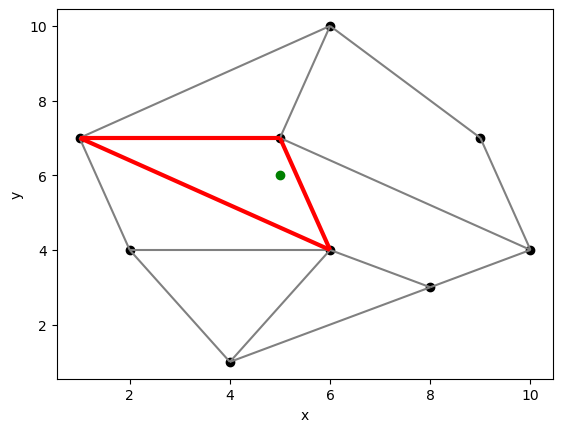

In [13]:
point3=(5,6)
vis3,e=separators_method_point_location_algorithm_visualiser(raw.vertices, raw.edges,point3)
vis3.show()

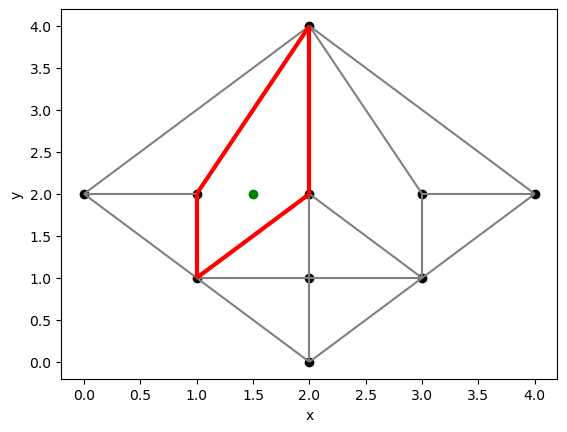

In [14]:
point2=(1.5,2)
vis2,edges=separators_method_point_location_algorithm_visualiser(raw.test2_vertices, raw.test2_edges,point2)
vis2.show()

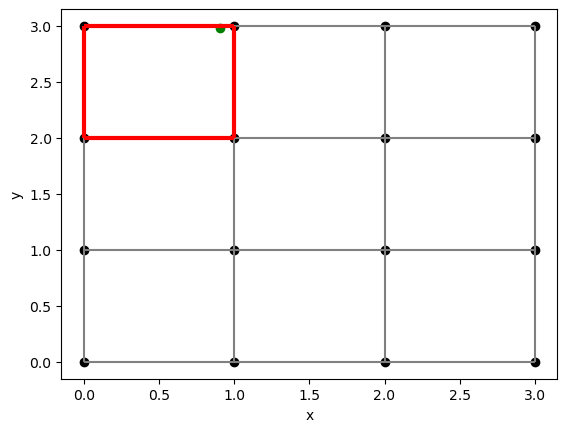

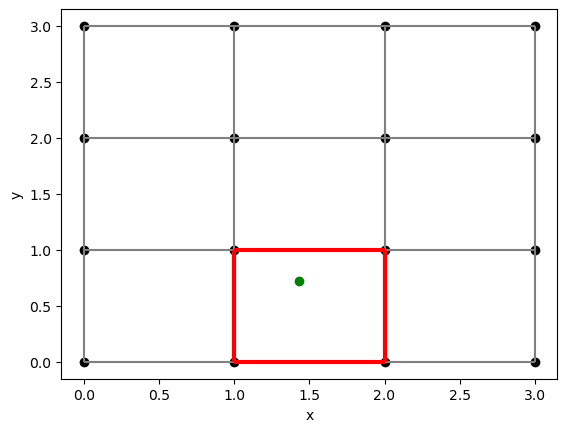

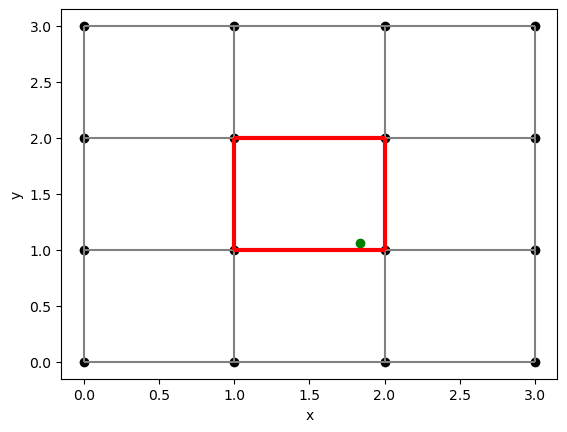

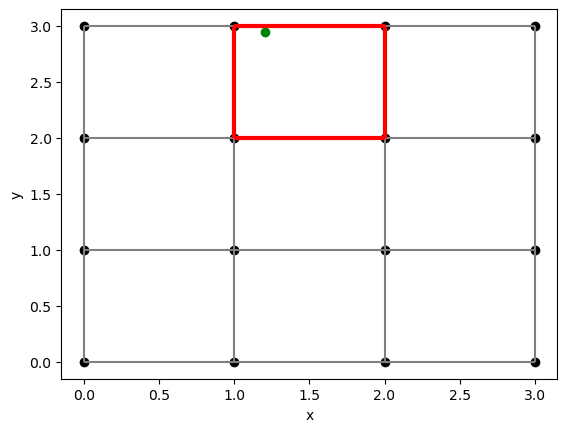

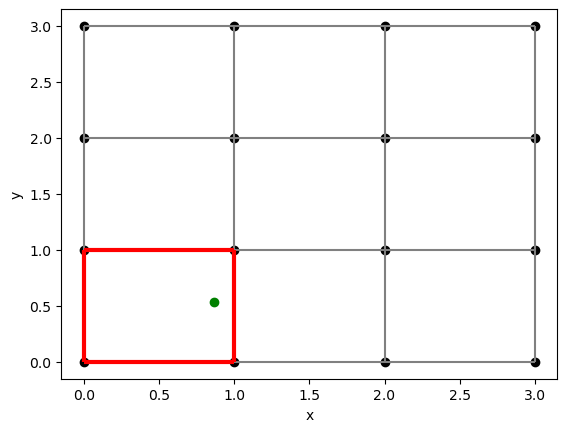

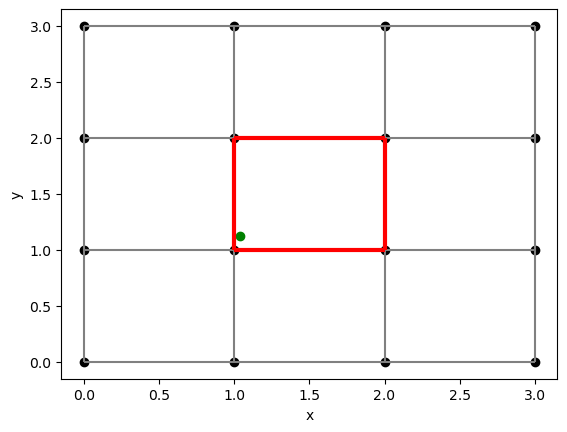

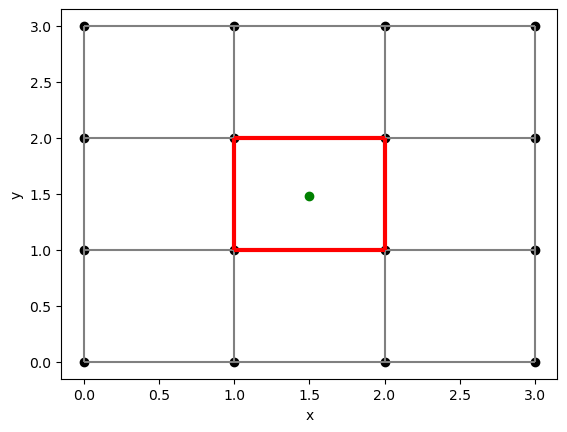

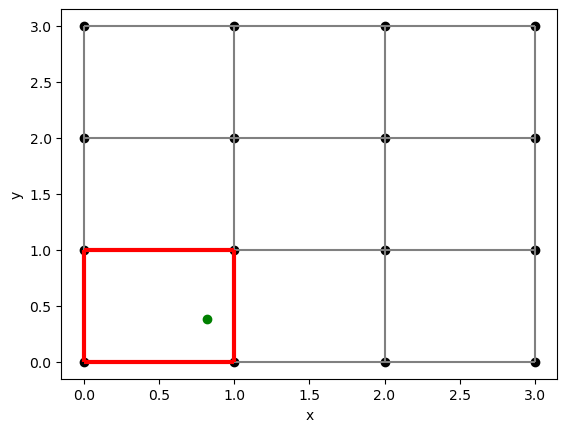

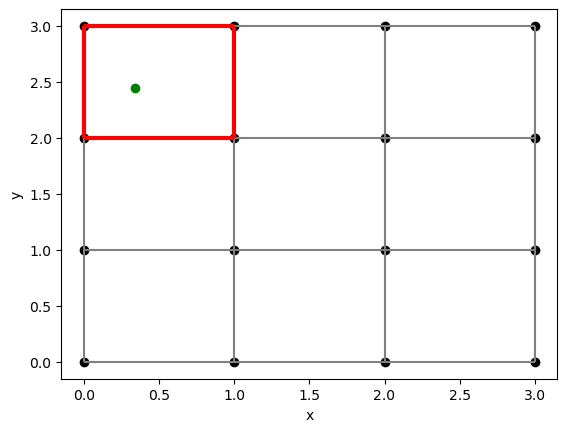

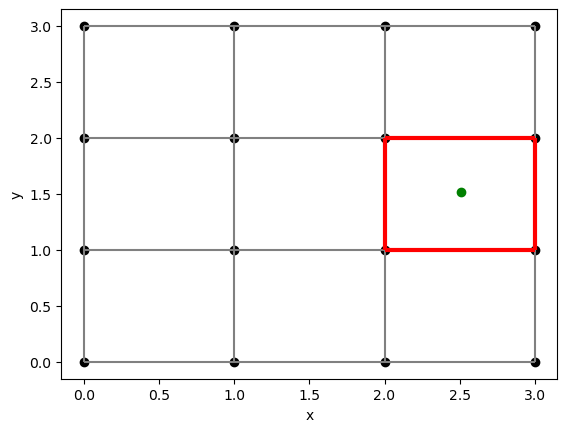

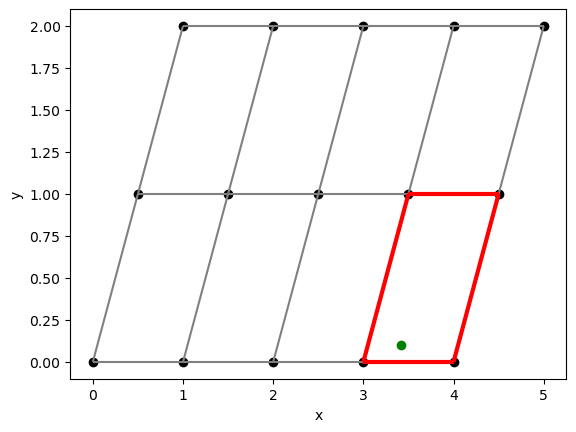

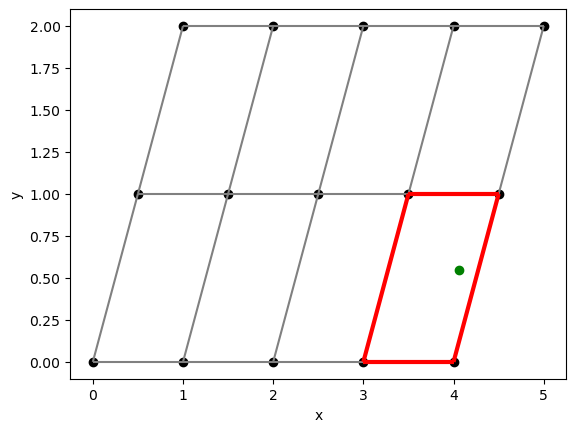

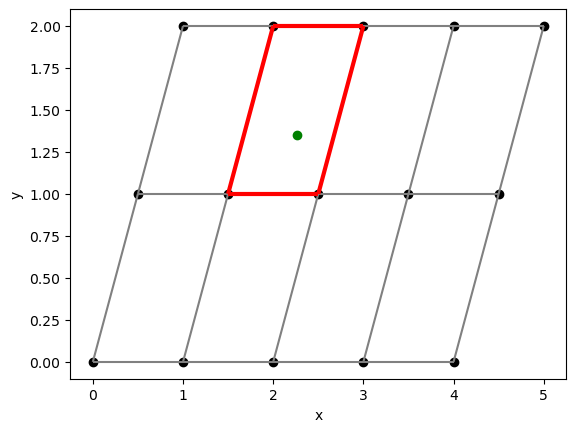

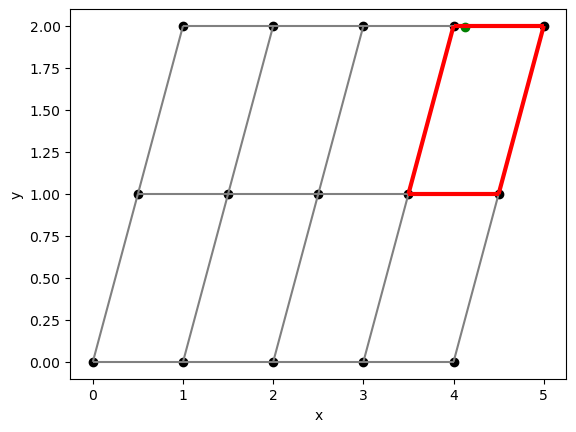

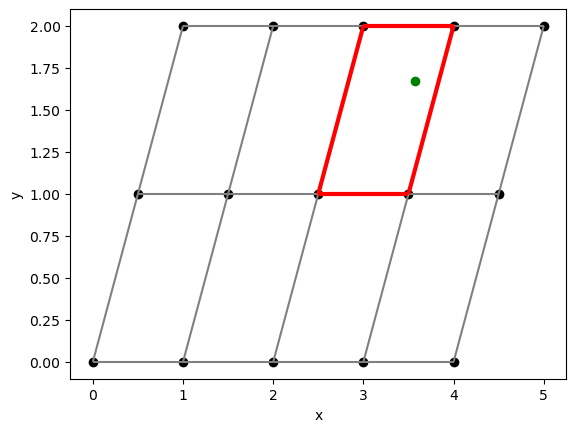

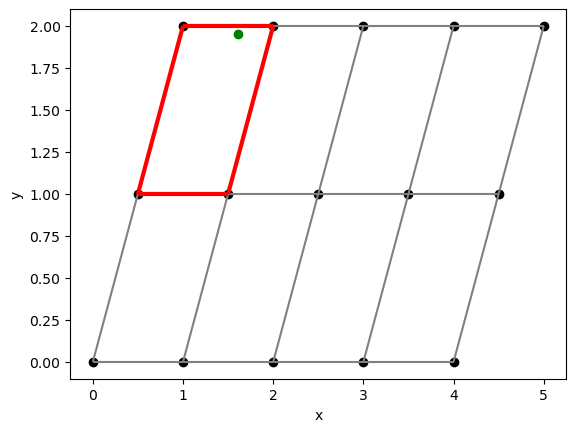

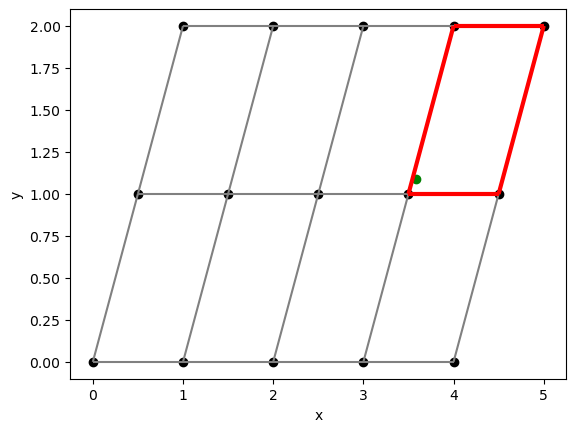

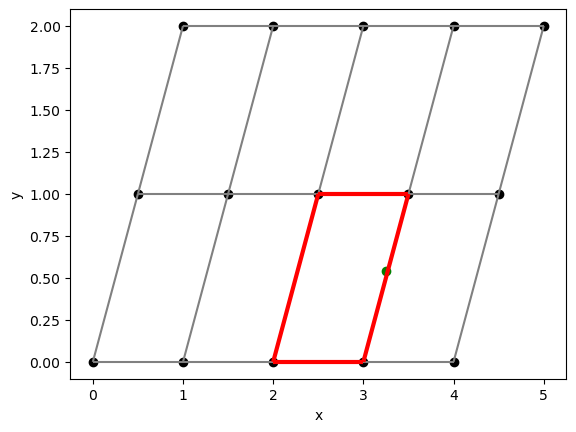

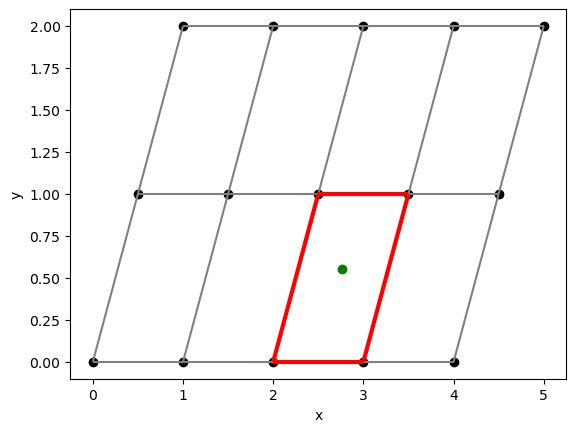

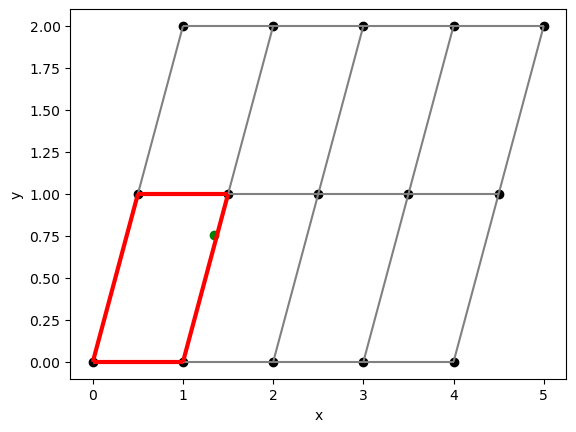

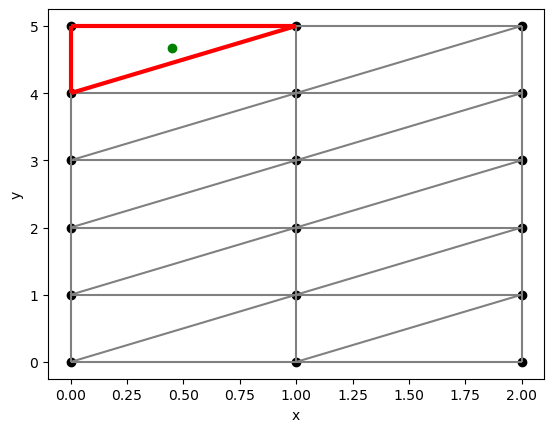

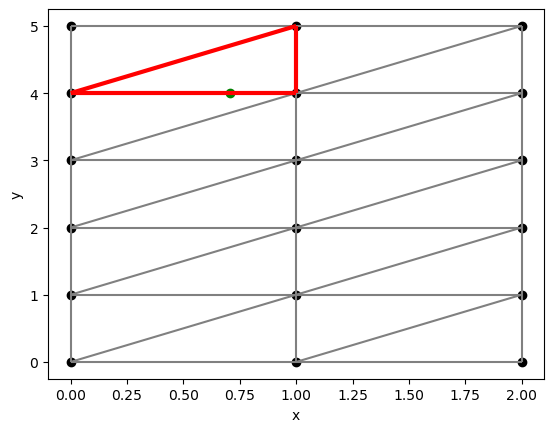

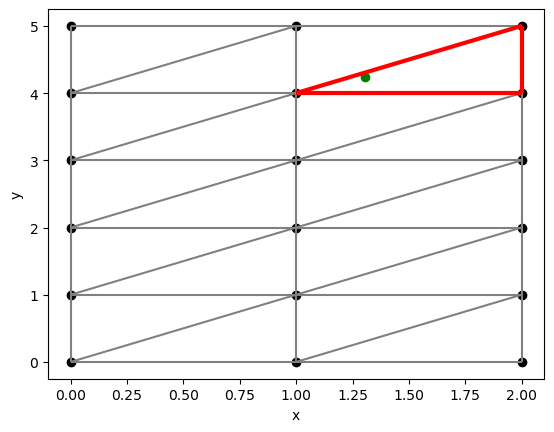

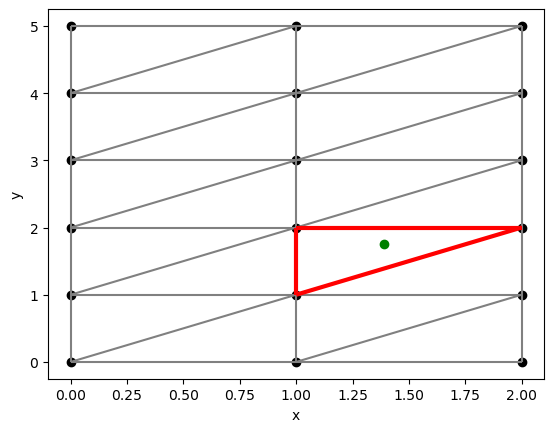

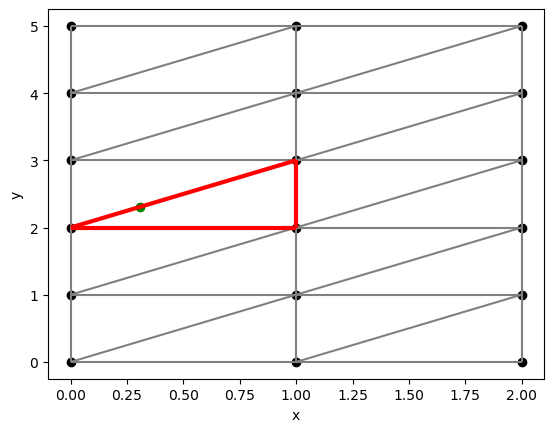

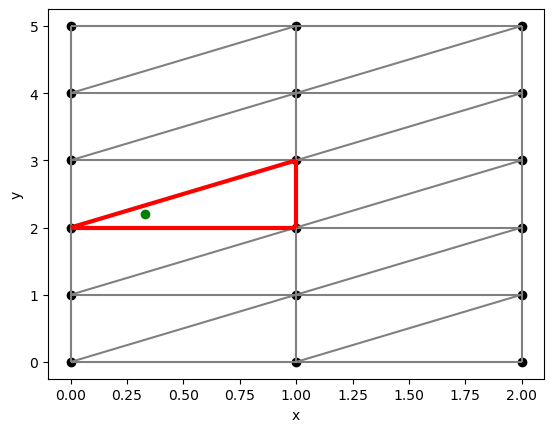

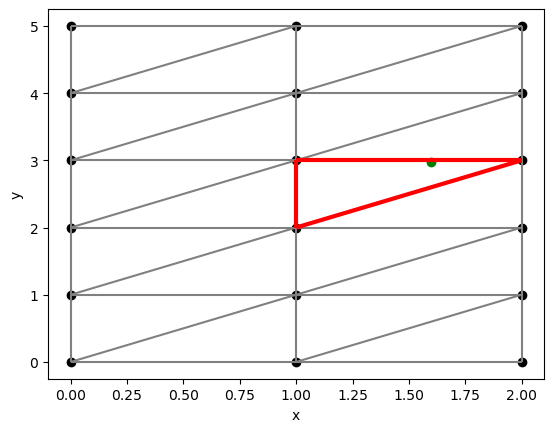

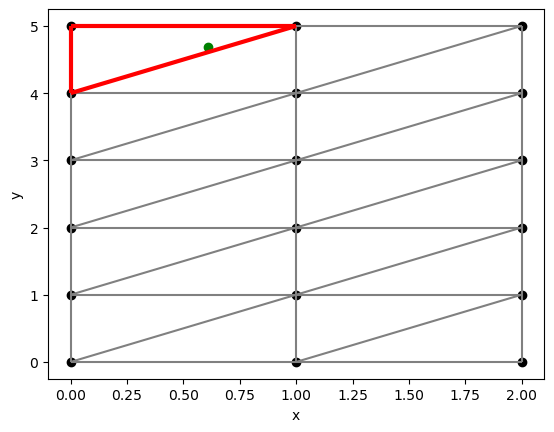

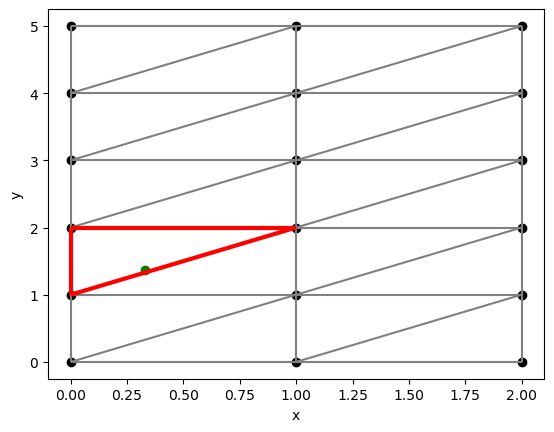

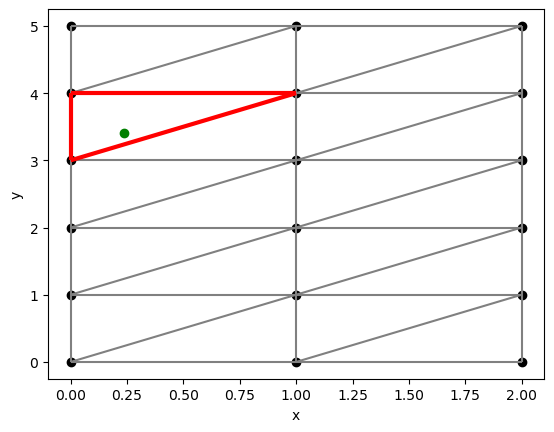

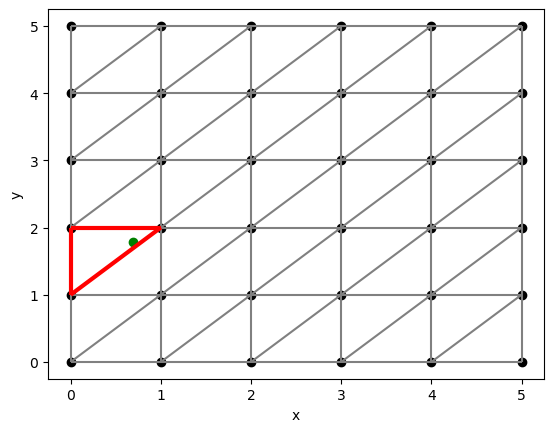

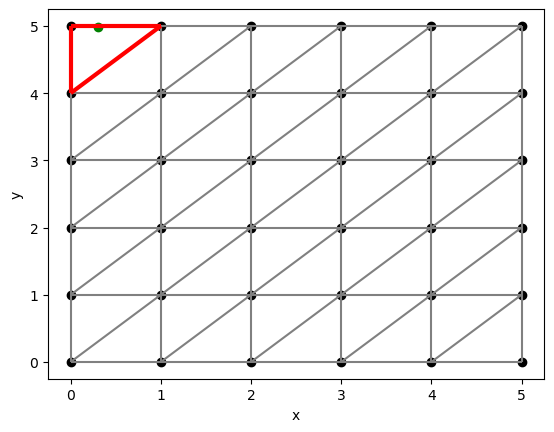

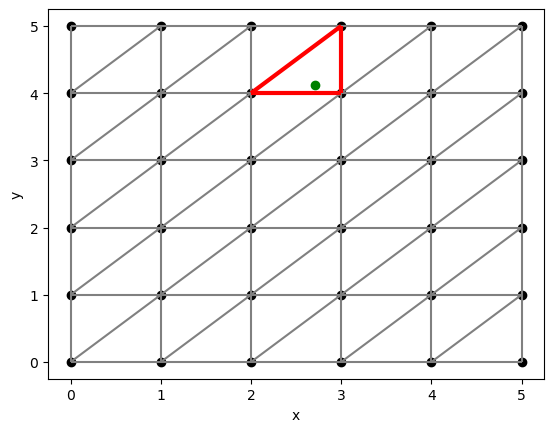

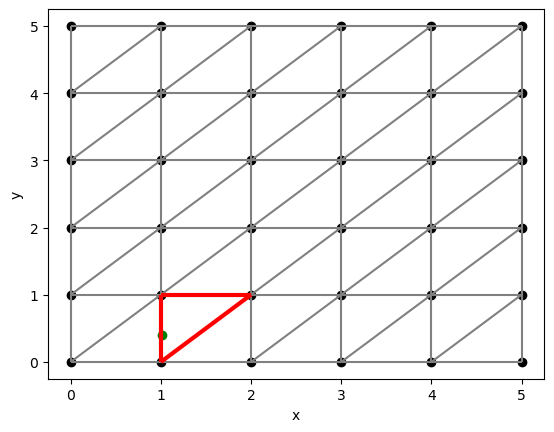

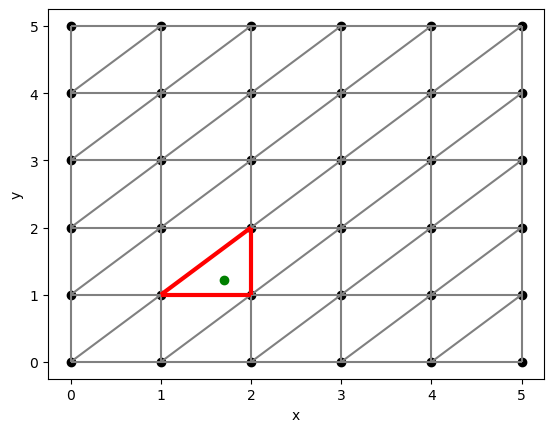

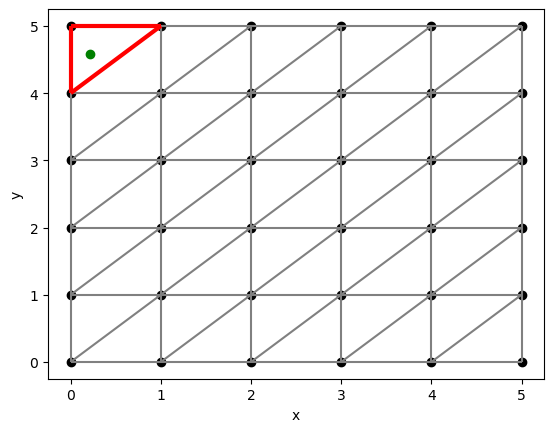

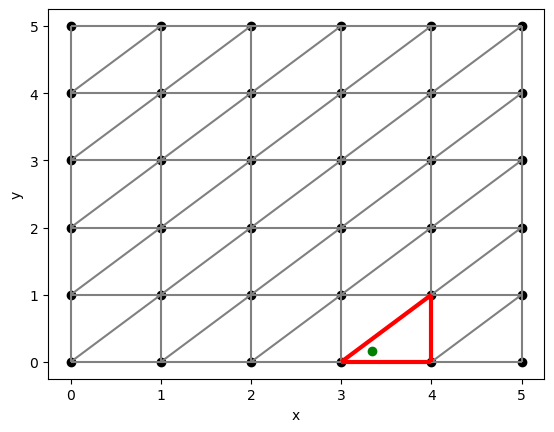

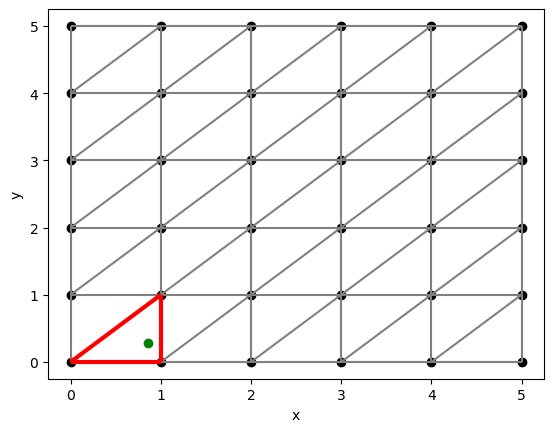

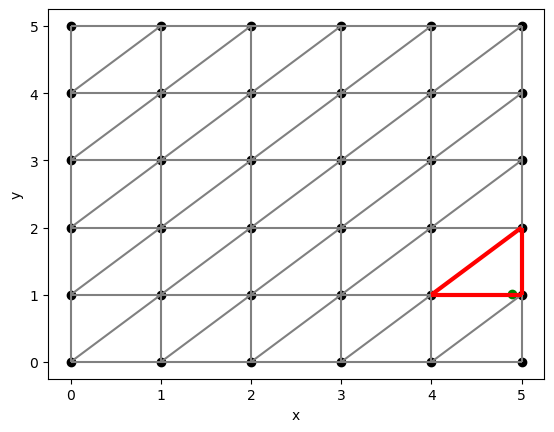

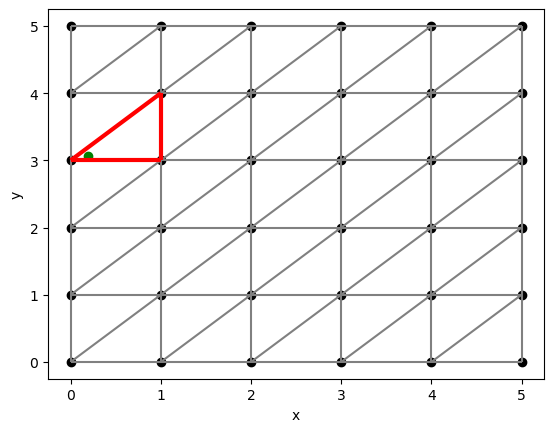

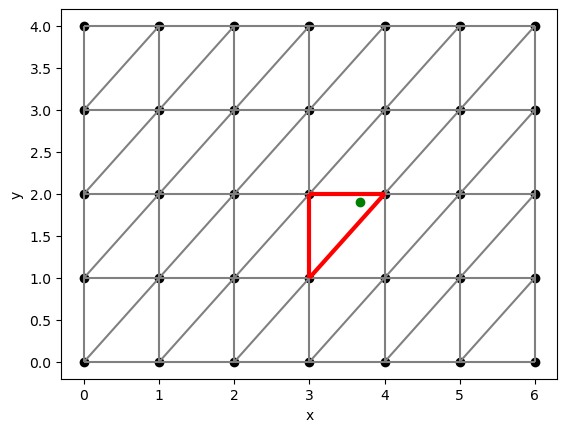

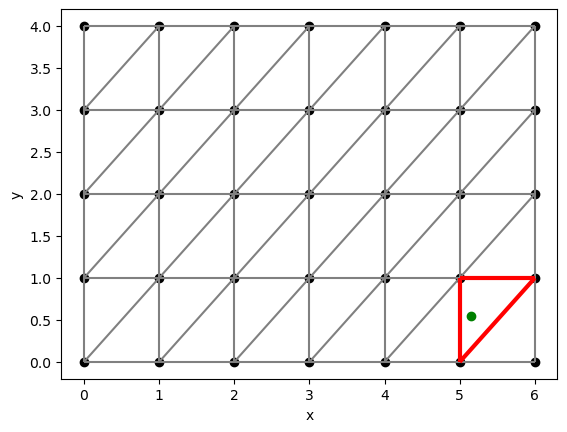

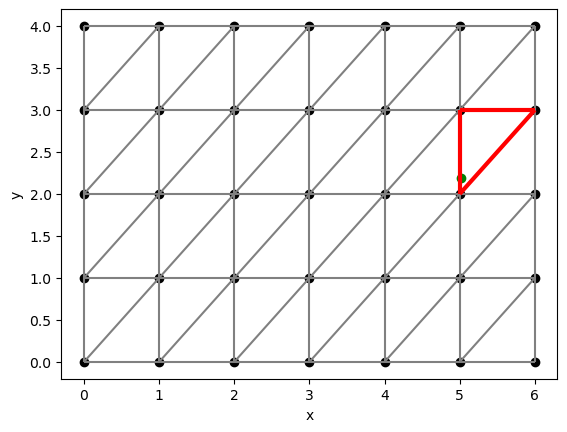

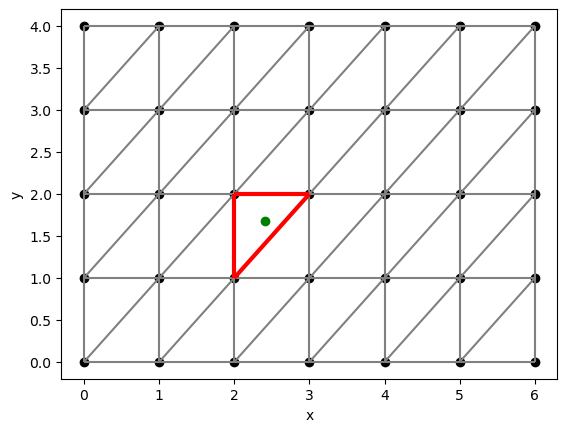

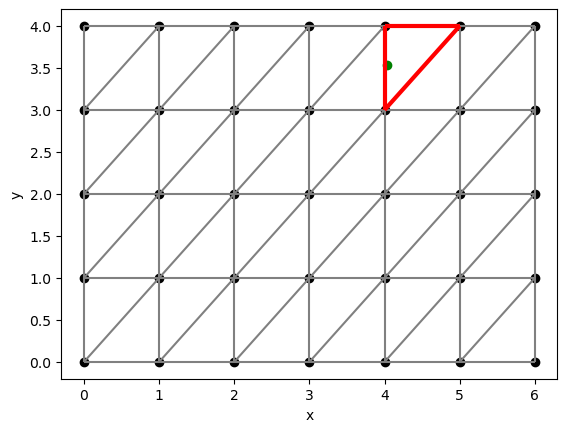

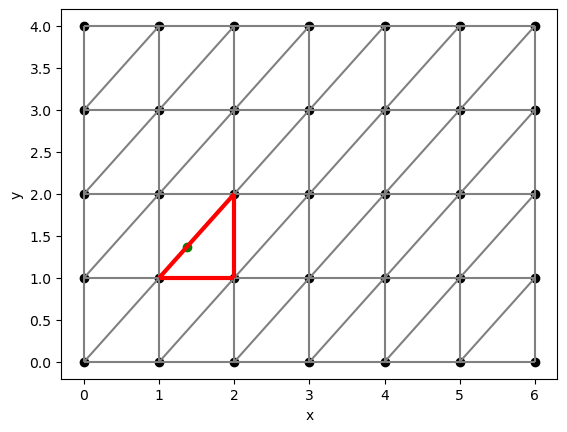

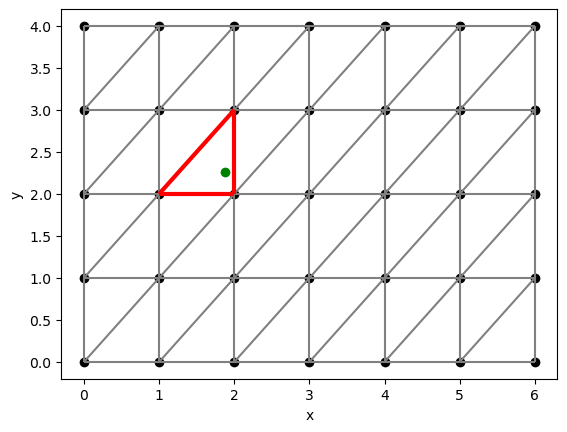

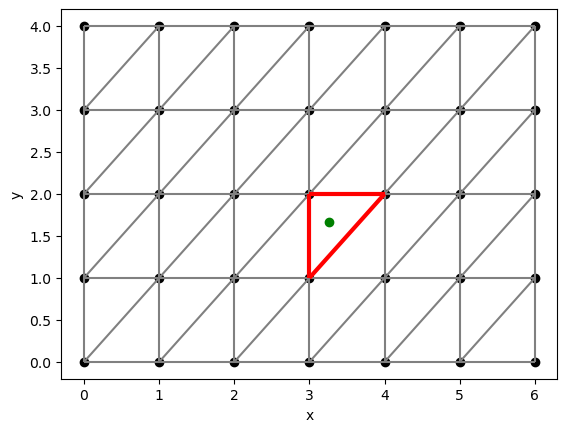

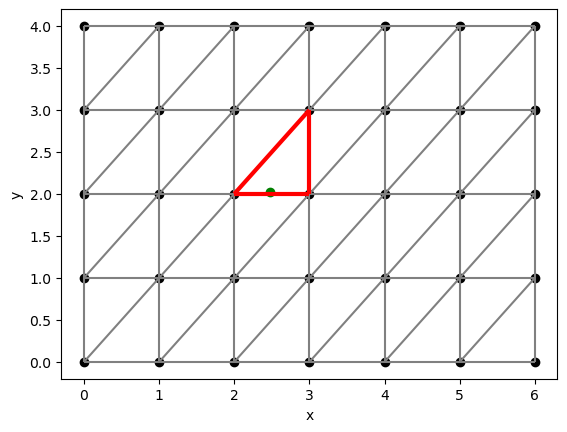

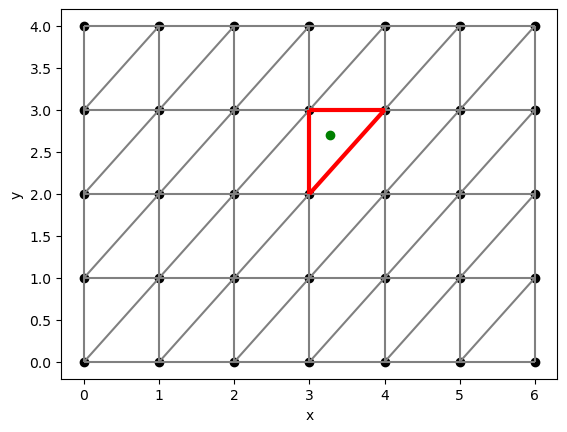

In [9]:
import random
import matplotlib.pyplot as plt

# --- Generatory Grafów ---

def generate_tri_grid(width, height):
    """
    Generuje siatkę trójkątów (oryginalna funkcja).
    """
    vertices = []
    edges = []
    
    for y in range(height + 1):
        for x in range(width + 1):
            vertices.append((float(x), float(y)))

    def get_idx(x, y):
        return y * (width + 1) + x

    for y in range(height):
        for x in range(width):
            u = get_idx(x, y)
            right = get_idx(x + 1, y)
            top = get_idx(x, y + 1)
            top_right = get_idx(x + 1, y + 1)

            edges.append((u, right))
            edges.append((u, top))
            edges.append((right, top_right))
            edges.append((top, top_right))
            edges.append((u, top_right)) # Przekątna

    unique_edges = set()
    for u, v in edges:
        if u < v: unique_edges.add((u, v))
        else: unique_edges.add((v, u))
            
    return vertices, list(unique_edges), 0 # 0 to skew (przesunięcie)

def generate_quad_grid(width, height, skew=0.0):
    """
    Generuje siatkę czworokątów (kwadraty lub równoległoboki).
    skew: parametr pochylenia siatki (0 = prosta siatka).
    """
    vertices = []
    edges = []
    
    # Wierzchołki z przesunięciem (skew)
    for y in range(height + 1):
        shift = y * skew
        for x in range(width + 1):
            vertices.append((float(x + shift), float(y)))

    def get_idx(x, y):
        return y * (width + 1) + x

    # Krawędzie (tylko poziome i pionowe/ukośne, bez przekątnych wewnątrz pola)
    # Poziome
    for y in range(height + 1):
        for x in range(width):
            u = get_idx(x, y)
            v = get_idx(x + 1, y)
            edges.append((u, v))
            
    # Pionowe (lub ukośne przy skew > 0)
    for x in range(width + 1):
        for y in range(height):
            u = get_idx(x, y)
            v = get_idx(x, y + 1)
            edges.append((u, v))

    unique_edges = set()
    for u, v in edges:
        if u < v: unique_edges.add((u, v))
        else: unique_edges.add((v, u))
            
    return vertices, list(unique_edges), skew

# --- Definicja Scenariuszy ---

scenarios = [
    # 1. Siatka Kwadratów (brak przekątnych)
    {
        "gen": lambda: generate_quad_grid(3, 3, skew=0.0), 
        "dims": (3, 3),
        "desc": "Siatka 3x3 (Kwadraty - regularne czworokąty)"
    },
    # 2. Siatka Równoległoboków (pochyła)
    {
        "gen": lambda: generate_quad_grid(4, 2, skew=0.5), 
        "dims": (4, 2),
        "desc": "Siatka 4x2 (Równoległoboki - pochylone czworokąty)"
    },
    # 3, 4, 5. Siatki Trójkątów (standardowe)
    {
        "gen": lambda: generate_tri_grid(2, 5), 
        "dims": (2, 5),
        "desc": "Siatka 2x5 (Trójkąty)"
    },
    {
        "gen": lambda: generate_tri_grid(5, 5), 
        "dims": (5, 5),
        "desc": "Siatka 5x5 (Trójkąty)"
    },
    {
        "gen": lambda: generate_tri_grid(6, 4), 
        "dims": (6, 4),
        "desc": "Siatka 6x4 (Trójkąty)"
    }
]

# --- Pętla Testowa ---

for s_idx, scen in enumerate(scenarios):
    desc = scen["desc"]
    w, h = scen["dims"]
    
    # Generowanie grafu
    vertices, edges, skew = scen["gen"]()
    
    # Generowanie 10 losowych punktów wewnątrz obszaru siatki
    # Uwzględniamy pochylenie (skew) przy generowaniu punktów
    points_to_check = []
    for _ in range(10):
        py = random.uniform(0, h)
        # Przesunięcie X zależy od wysokości Y w siatkach pochyłych
        shift_at_y = py * skew 
        # Losujemy X wewnątrz granic (przesuniętych)
        px = random.uniform(0 + shift_at_y, w + shift_at_y)
        points_to_check.append((px, py))
        
    # Uruchomienie testów dla punktów
    for p_idx, point in enumerate(points_to_check):
        
        try:
            # Uruchomienie Twojego algorytmu wizualizującego
            # Zakładam, że funkcja separators_method_point_location_algorithm_visualiser jest dostępna
            vis_obj, found_edges = separators_method_point_location_algorithm_visualiser(
                vertices, 
                edges, 
                point
            )
            
            # Wyświetlenie wizualizacji
            vis_obj.show()
            
        except Exception as e:
            print(f"     [BŁĄD] Nie udało się zlokalizować punktu: {e}")